<a href="https://colab.research.google.com/github/jameswebbtc/RAVDESS_Speech_Classification/blob/main/Approach1_SER_models_on_Mel_Spectrograms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Speech Emotion Recognition Using Mel Spectrograms**

In this notebook, we first develop a CNN model to carry out Speech Emotion Recognition (SER). We have already extracted mel spectrograms using 'Feature_extraction_and_Data_Augmentation.ipynb'. These spectrograms will be input to the CNN model for SER. The CNN model forms the baseline model for our study.

Among the various other models trained to improve the baseline model, we got the best performance by using a fine-tuned VGG16 + DNN model. The code for this network is also available in this notebook.

The other attempts included augmenting the dataset, and using the augmented data to train the VGG16 + DNN network. Since these models are not of the best performance, they have been added as part of the annexure at the end of this notebook.

#**Importing Necessary Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import time
import random

In [ ]:
import cv2
import PIL
from PIL import Image

In [ ]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras import regularizers
from keras.layers import Dropout

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

In [ ]:
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout, AveragePooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#**Baseline Model (Model 0):   CNN Model Without Data-Augmentation**

In this section, we carry out the model training and evaluation of a CNN model from scratch without data augmentation.

##**Splitting to Train, Validation and Test Datasets**


In [ ]:
# There are 8 classes in the dataset representing 8 emotions
classes = {1, 2, 3, 4, 5, 6, 7, 8}

In [ ]:
dataset_location = '/content/gdrive/MyDrive/Capstone_Project/Spectrogram_inputs'

In [ ]:
# Get a list of all image files in the dataset
image_files = glob.glob(os.path.join(dataset_location, "*.png"))

In [ ]:
# Extract label from filename
labels = [int(file.split("_")[7].split(".")[0]) for file in image_files]

In [ ]:
# Make a dataframe with the filepaths and labels
df = pd.DataFrame(image_files, columns=['File_Path'])
df['pos_labels'] = labels - np.ones(len(labels))
df.head(2)

,File_Path,pos_labels
0,/content/gdrive/MyDrive/Capstone_Project/Spect...,2.0
1,/content/gdrive/MyDrive/Capstone_Project/Spect...,4.0


In [ ]:
# Shuffle the rows
df= df.sample(frac=1)
df.head(2)

,File_Path,pos_labels
720,/content/gdrive/MyDrive/Capstone_Project/Spect...,6.0
1269,/content/gdrive/MyDrive/Capstone_Project/Spect...,5.0


### Resampling to balance classes

During EDA, it was seen that 'neutral' class had half the number of elements as compared to other classes. Hence, this class has been over-sampled.

In [ ]:
# Count the occurrences of each class
class_counts = df['pos_labels'].value_counts()

# Identify the minority class
minority_class = class_counts.idxmin()

# Identify the majority class
majority_class = class_counts.idxmax()

# Define oversampling strategy
oversample_strategy = {minority_class: class_counts[majority_class]}

# Oversample using RandomOverSampler
oversampler = RandomOverSampler(sampling_strategy=oversample_strategy, random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(df[['File_Path']], df['pos_labels'])

# Combine resampled data into a new DataFrame
df_resampled = pd.concat([X_resampled, y_resampled], axis=1)

In [ ]:
df_resampled

,File_Path,pos_labels
0,/content/gdrive/MyDrive/Capstone_Project/Spect...,6.0
1,/content/gdrive/MyDrive/Capstone_Project/Spect...,5.0
2,/content/gdrive/MyDrive/Capstone_Project/Spect...,2.0
3,/content/gdrive/MyDrive/Capstone_Project/Spect...,5.0
4,/content/gdrive/MyDrive/Capstone_Project/Spect...,1.0
...,...,...
1531,/content/gdrive/MyDrive/Capstone_Project/Spect...,0.0
1532,/content/gdrive/MyDrive/Capstone_Project/Spect...,0.0
1533,/content/gdrive/MyDrive/Capstone_Project/Spect...,0.0
1534,/content/gdrive/MyDrive/Capstone_Project/Spect...,0.0


In [ ]:
# Shuffle the rows
df_resampled= df_resampled.sample(frac=1)
df_resampled.head(2)

,File_Path,pos_labels
1503,/content/gdrive/MyDrive/Capstone_Project/Spect...,0.0
1206,/content/gdrive/MyDrive/Capstone_Project/Spect...,2.0


In [ ]:
# Split the dataset into training, validation and test sets
train_data, test_data = train_test_split(df_resampled, test_size=0.2, random_state=42,  stratify=df_resampled['pos_labels'])
test_data, val_data   = train_test_split(test_data, test_size=0.5, random_state=42,  stratify=test_data['pos_labels'])

In [ ]:
train_data.shape

(1228, 2)

In [ ]:
test_data.shape

(154, 2)

In [ ]:
val_data.shape

(154, 2)

In [ ]:
df_resampled.shape

(1536, 2)

In [ ]:
# Convert to numpy arrays for use in the subsequent sections
train_files, train_labels = train_data.values[:,0], train_data.values[:,1].astype('int32')
val_files, val_labels     = val_data.values[:,0], val_data.values[:,1].astype('int32')
test_files, test_labels   = test_data.values[:,0], test_data.values[:,1].astype('int32')

##**Preprocessing the Image**

In the preprocessing step, we do the following:
1. Convert the image to RGB (Initially, the image contained 4 channels. This will be reduced to 3 channels in this step.)
2. Resize the image to desired size
3. Normalise the pixel values to the range of [0,1]

In [ ]:
img = Image.open(image_files[200])

In [ ]:
img.size

(775, 462)

In [ ]:
def preprocess_image(file_path, target_size):
    img = Image.open(file_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0  # Normalize to [0, 1]
    return img_array

In [ ]:
# Original image size is (775, 462). We need to resize it
input_shape = (300,50,3)

train_images = np.array([preprocess_image(file, input_shape[:2]) for file in train_files])
val_images = np.array([preprocess_image(file, input_shape[:2]) for file in val_files])
test_images = np.array([preprocess_image(file, input_shape[:2]) for file in test_files])

In [ ]:
# Save the proccessed arrays
np.save('/content/gdrive/MyDrive/Capstone_Project/train_images_class_balanced_no_augm_color.npy', train_images)
np.save('/content/gdrive/MyDrive/Capstone_Project/val_images_class_balanced_no_augm_color.npy', val_images)
np.save('/content/gdrive/MyDrive/Capstone_Project/test_images_class_balanced_no_augm_color.npy', test_images)

In [ ]:
# Load the pre-processed arrays
input_shape = (300,50,3)

train_images = np.load('/content/gdrive/MyDrive/Capstone_Project/train_images_class_balanced_no_augm_color.npy')
val_images = np.load('/content/gdrive/MyDrive/Capstone_Project/val_images_class_balanced_no_augm_color.npy')
test_images = np.load('/content/gdrive/MyDrive/Capstone_Project/test_images_class_balanced_no_augm_color.npy')

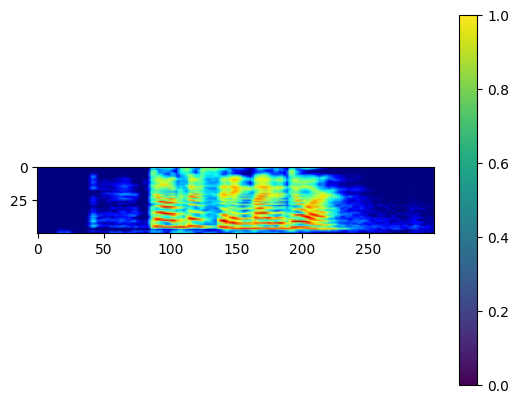

In [ ]:
my_array = test_images[1]

plt.imshow(my_array, cmap='viridis')  # You can choose a different colormap
plt.colorbar()  # Add a colorbar for reference
plt.show()

In [ ]:
# Use ImageDataGenerator to create batches of data for training and validation
batch_size           = 50
train_datagen        = ImageDataGenerator(rescale=1)
val_datagen          = ImageDataGenerator(rescale=1)
test_datagen         = ImageDataGenerator(rescale=1)

train_generator      = train_datagen.flow(train_images, train_labels, batch_size=batch_size)
validation_generator = val_datagen.flow(val_images, val_labels, batch_size=batch_size)
test_generator       = test_datagen.flow(test_images, test_labels, batch_size=test_images.shape[0],shuffle=False)


##**Training the Model**

In [ ]:
epochs = 50
lr     = 0.001

In [ ]:
# Model creation
model = Sequential([
    Conv2D(10, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(5, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.2),
    Dense(len(classes), activation='softmax')
])
adam_optimizer = Adam(learning_rate=lr)
model.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 48, 10)       280       
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 24, 10)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 22, 5)        455       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 11, 5)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 4015)              0         
                                                                 
 dense (Dense)               (None, 50)                2

In [ ]:
# Model training
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=epochs
)

model.save("/content/gdrive/MyDrive/Capstone_Project/trained_model.h5")

Epoch 1/50
25/25 [==============================] - 15s 481ms/step - loss: 2.8431 - accuracy: 0.1726 - val_loss: 2.4821 - val_accuracy: 0.2338
Epoch 2/50
25/25 [==============================] - 13s 508ms/step - loss: 2.2805 - accuracy: 0.2932 - val_loss: 2.0602 - val_accuracy: 0.3831
Epoch 3/50
25/25 [==============================] - 9s 380ms/step - loss: 1.9755 - accuracy: 0.3901 - val_loss: 1.8814 - val_accuracy: 0.4481
Epoch 4/50
25/25 [==============================] - 10s 406ms/step - loss: 1.8023 - accuracy: 0.4471 - val_loss: 1.7915 - val_accuracy: 0.4610
Epoch 5/50
25/25 [==============================] - 8s 337ms/step - loss: 1.7042 - accuracy: 0.4625 - val_loss: 1.6425 - val_accuracy: 0.5130
Epoch 6/50
25/25 [==============================] - 12s 464ms/step - loss: 1.5842 - accuracy: 0.5285 - val_loss: 1.6642 - val_accuracy: 0.5260
Epoch 7/50
25/25 [==============================] - 10s 378ms/step - loss: 1.5462 - accuracy: 0.5252 - val_loss: 1.6527 - val_accuracy: 0.5195
E

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


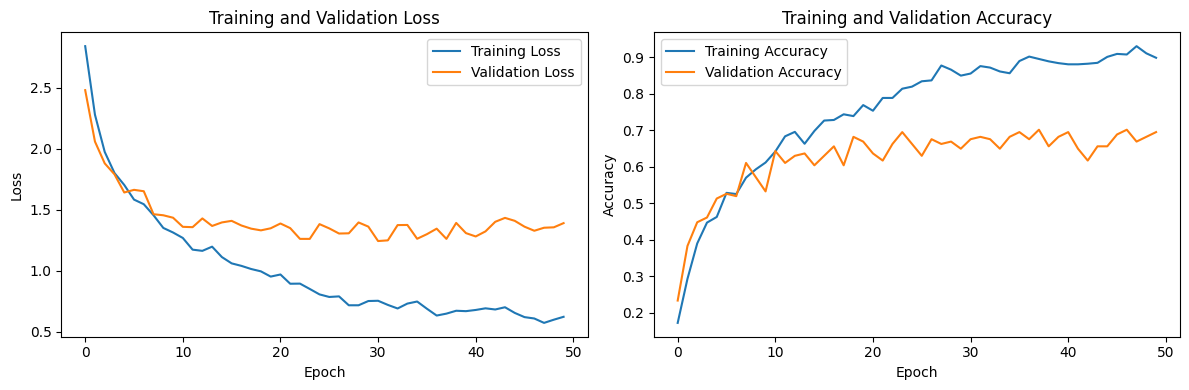

In [ ]:
# Plot training and validation loss and accuracy in subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot accuracy
axes[1].plot(history.history['accuracy'], label='Training Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

##**Testing the Model**

In [ ]:
predictions      = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

1/1 [==============================] - 1s 1s/step


In [ ]:
true_labels = test_labels

In [ ]:
# Compute accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy*100:.2f} %')

# Compute precision, recall, and confusion matrix
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
print(f'Weighted Precision: {precision*100:.2f} %')
print(f'Weighted Recall: {recall*100:.2f} %')

Accuracy: 68.18 %
Weighted Precision: 70.21 %
Weighted Recall: 68.18 %


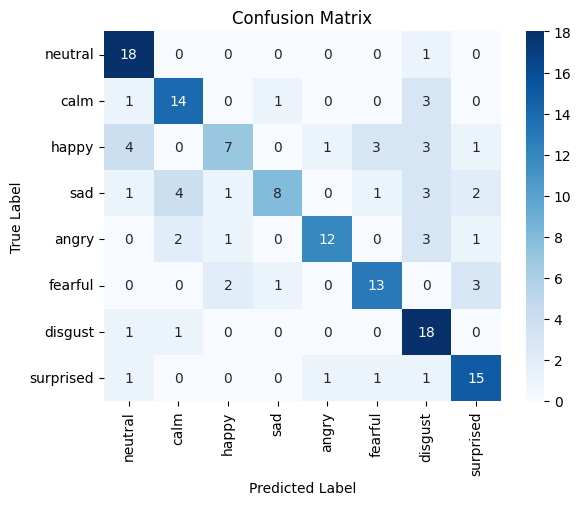

In [ ]:
true_labels = true_labels + 1
predicted_labels = predicted_labels + 1
confusion_mat = confusion_matrix(true_labels, predicted_labels)

class_names = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
# Visualize the confusion matrix as a Seaborn heatmap
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

#**Best Model Achieved with Mel Spectrograms (Model 1):  Fine-tuning VGG16**

This section presents the training and evaluation of the best model we achieved using Mel spectrograms. The model was obtained by fine-tuning VGG16 model followed by a DNN classification head.

In [ ]:
# Use ImageDataGenerator to create batches of data for training and validation
batch_size           = 50
train_datagen        = ImageDataGenerator(rescale=1)
val_datagen          = ImageDataGenerator(rescale=1)
test_datagen         = ImageDataGenerator(rescale=1)

train_generator      = train_datagen.flow(train_images, train_labels, batch_size=batch_size)
validation_generator = val_datagen.flow(val_images, val_labels, batch_size=batch_size)
test_generator       = test_datagen.flow(test_images, test_labels, batch_size=test_images.shape[0],shuffle=False)


##**Training the Model**

In [ ]:
epochs = 25
lr     = 0.001

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(50,300,3))

# Modify the input layer for grayscale images
inputs = layers.Input(shape=input_shape)
# Replicate the single channel to create a three-channel image
replicated_inputs = inputs #layers.concatenate([inputs, inputs, inputs], axis=-1)

# Use the VGG16 base model
x = base_model(replicated_inputs)

# Add your custom dense layers
x = Flatten()(x)
x = Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.2)(x)
x = Dense(100, activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
output = Dense(len(classes), activation='softmax')(x)  # Set num_classes to the number of your classes

# Create the fine-tuned model
model = Model(inputs=inputs, outputs=output)

# Freeze layers up to a certain point (up to the last 5 layers in this case)
for layer in base_model.layers[:-2]:
    layer.trainable = False

adam_optimizer = Adam(learning_rate=lr)
model.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 300, 50, 3)]      0         
                                                                 
 vgg16 (Functional)          (None, 1, 9, 512)         14714688  
                                                                 
 flatten_11 (Flatten)        (None, 4608)              0         
                                                                 
 dense_33 (Dense)            (None, 256)               1179904   
                                                                 
 dropout_19 (Dropout)        (None, 256)               0         
                                                                 
 dense_34 (Dense)            (None, 100)               25700     
                                                                 
 dropout_20 (Dropout)        (None, 100)               0  

In [ ]:
# Model training
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=epochs
)

model.save("/content/gdrive/MyDrive/Capstone_Project/trained_model_vgg.h5")

Epoch 1/25
25/25 [==============================] - 4s 108ms/step - loss: 5.9886 - accuracy: 0.1531 - val_loss: 4.1287 - val_accuracy: 0.2338
Epoch 2/25
25/25 [==============================] - 2s 95ms/step - loss: 3.5919 - accuracy: 0.2386 - val_loss: 2.9724 - val_accuracy: 0.4351
Epoch 3/25
25/25 [==============================] - 2s 99ms/step - loss: 2.7858 - accuracy: 0.3779 - val_loss: 2.2895 - val_accuracy: 0.5779
Epoch 4/25
25/25 [==============================] - 2s 98ms/step - loss: 2.2733 - accuracy: 0.4805 - val_loss: 1.9156 - val_accuracy: 0.6039
Epoch 5/25
25/25 [==============================] - 2s 98ms/step - loss: 1.9082 - accuracy: 0.5733 - val_loss: 1.6749 - val_accuracy: 0.6169
Epoch 6/25
25/25 [==============================] - 2s 95ms/step - loss: 1.6411 - accuracy: 0.6295 - val_loss: 1.5266 - val_accuracy: 0.6429
Epoch 7/25
25/25 [==============================] - 2s 96ms/step - loss: 1.4139 - accuracy: 0.6808 - val_loss: 1.4065 - val_accuracy: 0.6558
Epoch 8/25
2

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


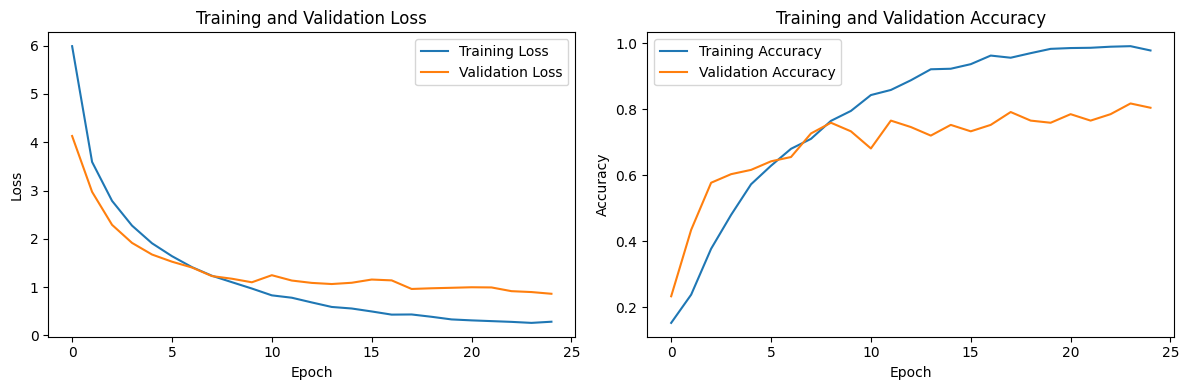

In [ ]:
# Plot training and validation loss and accuracy in subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot accuracy
axes[1].plot(history.history['accuracy'], label='Training Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()


plt.tight_layout()
plt.show()

##**Testing the Model**

In [ ]:
predictions      = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

1/1 [==============================] - 13s 13s/step


In [ ]:
true_labels = test_labels

In [ ]:
# Compute accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy*100:.2f} %')

# Compute precision, recall, and confusion matrix
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
print(f'Weighted Precision: {precision*100:.2f} %')
print(f'Weighted Recall: {recall*100:.2f} %')

Accuracy: 75.97 %
Weighted Precision: 76.68 %
Weighted Recall: 75.97 %


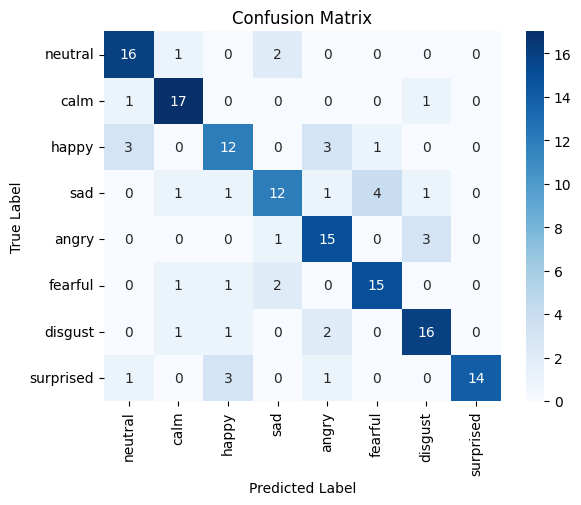

In [ ]:
true_labels = true_labels + 1
predicted_labels = predicted_labels + 1
confusion_mat = confusion_matrix(true_labels, predicted_labels)

class_names = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
# Visualize the confusion matrix as a Seaborn heatmap
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

#**Conclusion**

In this notebook we trained two models for SER from Mel spectrograms. These were trained on RAVDESS dataset after removing class imbalance by oversampling 'neutral' class:
* Model 0 : This is a CNN model trained from scratch using the dataset and forms the baseline model for this study.
* Model 1 : This is Fine tuned VGG16 + DNN model


A major challenge in training the SER model was that the CNN easily overfits the data. To reduce this, we took the following steps:
1. Added L2 regularisation to the convolution and dense layers
2. Added a dropout of 20% to the dense layer after flattening the output of convolution layers
3. Chose a lower leraning rate of 0.001 for the Adam optimizer


Further, we trained a model by fine-tuning VGG16 followed by a DNN classification head.

The comparion of various performance metrics from both the models trained are given below:

------------------------------------------------------------
Performance Metric             |  Model 0    |   Model 1   
-------------------------------|-------------|--------------
Accuracy(%)                    |  68.18       |  75.97
Weighted Precision (%)         |  70.21       |  76.68
Weighted Recall (%)            |  68.18       |  75.97


Thus, using fine-tuning of VGG16 helped to overcome the limitation in the dataset available and led to a  considerable improvement in performance.


------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------

#**ANNEXURE**
In this annexure, we add our experiments to improve the model performance with data augmentation. Both the networks presented so far were trained with a 10 times augmented dataset generated in 'Feature_extraction_and_Data_Augmentation_for_Model1.ipynb'.

However, these were of sub-optimal performance and hence are included in the annexure.

##**CNN Model With Data-Augmentation**

In this section, we carry out the model training and evaluation with the augmented data. Data augmentation was carried out by stretching the audio, pitch shifting and adding noise.

Since the 'neutral' class had half the datapoints in the original dataset as compared to other target classes, we also augmented the 'neutral' class by double the amount than the augmentation in other classes. This removes class imbalance in the augmented dataset.

The inputs for this model were generated using the notebook '
Feature_extraction_and_Data_Augmentation_for_Model1.ipynb'.

###**Splitting to Train, Validation and Test Datasets**


In [ ]:
# There are 8 classes in the dataset representing 8 emotions
classes = {1, 2, 3, 4, 5, 6, 7, 8}

In [ ]:
dataset_location = '/content/gdrive/MyDrive/Capstone_Project/Spectrogram_inputs_with_data_augm_tmp'

In [ ]:
#@title Training Data
dataset_location_train   = dataset_location+ '/train'
# Get a list of all image files in the dataset
image_files = glob.glob(os.path.join(dataset_location_train, "*.png"))
# Extract label from filename
labels = [int(file.split("_")[11].split(".")[0]) for file in image_files]
# Make a dataframe with the filepaths and labels
train_data = pd.DataFrame(image_files, columns=['File_Path'])
train_data['pos_labels'] = labels - np.ones(len(labels))
train_data.head(2)

,File_Path,pos_labels
0,/content/gdrive/MyDrive/Capstone_Project/Spect...,5.0
1,/content/gdrive/MyDrive/Capstone_Project/Spect...,5.0


In [ ]:
#@title Validation Data
dataset_location_val  = dataset_location+ '/val'
# Get a list of all image files in the dataset
image_files = glob.glob(os.path.join(dataset_location_val, "*.png"))
# Extract label from filename
labels = [int(file.split("_")[11].split(".")[0]) for file in image_files]
# Make a dataframe with the filepaths and labels
val_data = pd.DataFrame(image_files, columns=['File_Path'])
val_data['pos_labels'] = labels - np.ones(len(labels))
val_data.head(2)

,File_Path,pos_labels
0,/content/gdrive/MyDrive/Capstone_Project/Spect...,7.0
1,/content/gdrive/MyDrive/Capstone_Project/Spect...,7.0


In [ ]:
#@title Test Data
dataset_location_test   = dataset_location+ '/test'
# Get a list of all image files in the dataset
image_files = glob.glob(os.path.join(dataset_location_test, "*.png"))
# Extract label from filename
labels = [int(file.split("_")[11].split(".")[0]) for file in image_files]
# Make a dataframe with the filepaths and labels
test_data = pd.DataFrame(image_files, columns=['File_Path'])
test_data['pos_labels'] = labels - np.ones(len(labels))
test_data.head(2)

,File_Path,pos_labels
0,/content/gdrive/MyDrive/Capstone_Project/Spect...,2.0
1,/content/gdrive/MyDrive/Capstone_Project/Spect...,7.0


In [ ]:
train_data.shape

(9210, 2)

In [ ]:
test_data.shape

(288, 2)

In [ ]:
val_data.shape

(2310, 2)

In [ ]:
# Convert to numpy arrays for use in the subsequent sections
train_files, train_labels = train_data.values[:,0], train_data.values[:,1].astype('int32')
val_files, val_labels     = val_data.values[:,0], val_data.values[:,1].astype('int32')
test_files, test_labels   = test_data.values[:,0], test_data.values[:,1].astype('int32')

###**Preprocessing the Image**

In the preprocessing step, we follow the same preprocessing steps used for model without data augmentation.

In [ ]:
# Original image size is (775, 462). We need to resize it
input_shape = (300,50,3)

train_images = np.array([preprocess_image(file, input_shape[:2]) for file in train_files])
val_images = np.array([preprocess_image(file, input_shape[:2]) for file in val_files])
test_images = np.array([preprocess_image(file, input_shape[:2]) for file in test_files])

In [ ]:
# Save the proccessed arrays
np.save('/content/gdrive/MyDrive/Capstone_Project/train_images_with_augm.npy', train_images)
np.save('/content/gdrive/MyDrive/Capstone_Project/val_images_with_augm.npy', val_images)
np.save('/content/gdrive/MyDrive/Capstone_Project/test_images_with_augm.npy', test_images)

In [ ]:
# Load the pre-processed arrays
input_shape = (300,50,3)
train_images = np.load('/content/gdrive/MyDrive/Capstone_Project/train_images_with_augm.npy')
val_images = np.load('/content/gdrive/MyDrive/Capstone_Project/val_images_with_augm.npy')
test_images = np.load('/content/gdrive/MyDrive/Capstone_Project/test_images_with_augm.npy')

In [ ]:
# Use ImageDataGenerator to create batches of data for training and validation
batch_size           = 50
train_datagen        = ImageDataGenerator(rescale=1)
val_datagen          = ImageDataGenerator(rescale=1)
test_datagen         = ImageDataGenerator(rescale=1)

train_generator      = train_datagen.flow(train_images, train_labels, batch_size=batch_size)
validation_generator = val_datagen.flow(val_images, val_labels, batch_size=batch_size)
test_generator       = test_datagen.flow(test_images, test_labels, batch_size=test_images.shape[0],shuffle=False)


###**Training the Model**

In [ ]:
epochs = 50
lr     = 0.001

In [ ]:
# Model creation
model = Sequential([
    Conv2D(10, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=input_shape),
    AveragePooling2D((2, 2)),
    Conv2D(10, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    AveragePooling2D((2, 2)),
    Conv2D(5, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    AveragePooling2D((2, 2)),
    Flatten(),
    Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.2),
    Dense(len(classes), activation='softmax')
])
adam_optimizer = Adam(learning_rate=lr)
model.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 48, 10)       280       
                                                                 
 average_pooling2d (Average  (None, 149, 24, 10)       0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 22, 10)       910       
                                                                 
 average_pooling2d_1 (Avera  (None, 73, 11, 10)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 9, 5)          455       
                                                                 
 average_pooling2d_2 (Avera  (None, 35, 4, 5)          0

In [ ]:
# Model training
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=epochs
)

model.save("/content/gdrive/MyDrive/Capstone_Project/trained_model_with_data_augm.h5")

Epoch 1/50
185/185 [==============================] - 17s 26ms/step - loss: 2.0979 - accuracy: 0.3125 - val_loss: 1.7202 - val_accuracy: 0.4229
Epoch 2/50
185/185 [==============================] - 3s 18ms/step - loss: 1.4966 - accuracy: 0.5250 - val_loss: 1.5764 - val_accuracy: 0.4658
Epoch 3/50
185/185 [==============================] - 3s 19ms/step - loss: 1.2463 - accuracy: 0.6280 - val_loss: 1.6930 - val_accuracy: 0.4879
Epoch 4/50
185/185 [==============================] - 5s 28ms/step - loss: 1.1168 - accuracy: 0.6789 - val_loss: 1.6658 - val_accuracy: 0.5035
Epoch 5/50
185/185 [==============================] - 3s 18ms/step - loss: 1.0038 - accuracy: 0.7325 - val_loss: 1.6695 - val_accuracy: 0.5173
Epoch 6/50
185/185 [==============================] - 5s 25ms/step - loss: 0.9239 - accuracy: 0.7670 - val_loss: 1.6759 - val_accuracy: 0.5381
Epoch 7/50
185/185 [==============================] - 4s 22ms/step - loss: 0.8546 - accuracy: 0.7972 - val_loss: 1.7892 - val_accuracy: 0.512

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


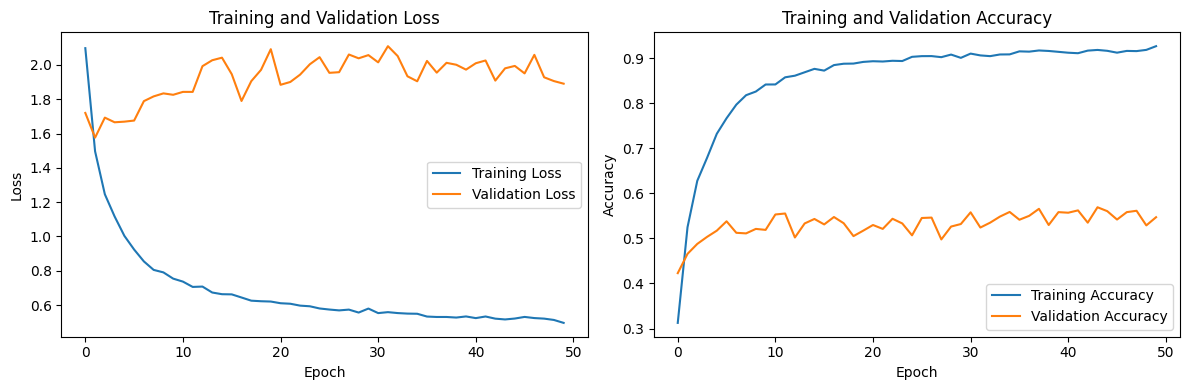

In [ ]:
# Plot training and validation loss and accuracy in subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot accuracy
axes[1].plot(history.history['accuracy'], label='Training Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

###**Testing the Model**

In [ ]:
predictions      = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

1/1 [==============================] - 1s 644ms/step


In [ ]:
true_labels = test_labels

In [ ]:
# Compute accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy*100:.2f} %')

# Compute precision, recall, and confusion matrix
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
print(f'Weighted Precision: {precision*100:.2f} %')
print(f'Weighted Recall: {recall*100:.2f} %')

Accuracy: 57.64 %
Weighted Precision: 57.15 %
Weighted Recall: 57.64 %


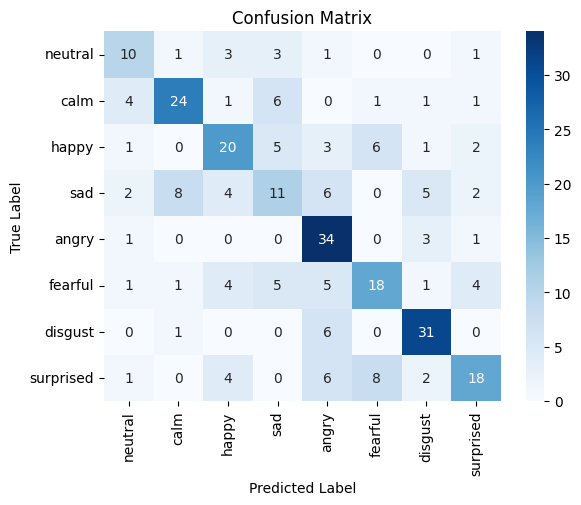

In [ ]:
true_labels = true_labels + 1
predicted_labels = predicted_labels + 1
confusion_mat = confusion_matrix(true_labels, predicted_labels)

class_names = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
# Visualize the confusion matrix as a Seaborn heatmap
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

In [ ]:
# Load the pre-processed arrays
input_shape = (300,50,3)
train_images = np.load('/content/gdrive/MyDrive/Capstone_Project/train_images_with_augm.npy')
val_images = np.load('/content/gdrive/MyDrive/Capstone_Project/val_images_with_augm.npy')
test_images = np.load('/content/gdrive/MyDrive/Capstone_Project/test_images_with_augm.npy')

In [ ]:
# Use ImageDataGenerator to create batches of data for training and validation
batch_size           = 1000
train_datagen        = ImageDataGenerator(rescale=1)
val_datagen          = ImageDataGenerator(rescale=1)
test_datagen         = ImageDataGenerator(rescale=1)

train_generator      = train_datagen.flow(train_images, train_labels, batch_size=batch_size)
validation_generator = val_datagen.flow(val_images, val_labels, batch_size=batch_size)
test_generator       = test_datagen.flow(test_images, test_labels, batch_size=test_images.shape[0],shuffle=False)


##**Fine Tuning VGG16 along with Data Augmentation**

In this section, we train the VGG16 + DNN network with the augmented dataset

###**Training the Model**

In [ ]:
epochs = 50
lr     = 0.001


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(50,300,3))

# Modify the input layer for grayscale images
inputs = layers.Input(shape=input_shape)
# Replicate the single channel to create a three-channel image
replicated_inputs = inputs #layers.concatenate([inputs, inputs, inputs], axis=-1)

# Use the VGG16 base model
x = base_model(replicated_inputs)
# Flatten
x = Flatten()(x)
# Add your custom dense layers
x = Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.2)(x)
x = Dense(100, activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
output = Dense(len(classes), activation='softmax')(x)  # Set num_classes to the number of your classes

# Create the fine-tuned model
model = Model(inputs=inputs, outputs=output)

# Freeze layers up to a certain point (up to the last 5 layers in this case)
for layer in base_model.layers[:-2]:
    layer.trainable = False

adam_optimizer = Adam(learning_rate=lr)
model.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 50, 3)]      0         
                                                                 
 vgg16 (Functional)          (None, 1, 9, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               25700     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0     

In [ ]:
# Model training
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=epochs
)

model.save("/content/gdrive/MyDrive/Capstone_Project/trained_model_vgg_with_augm.h5")

Epoch 1/50
10/10 [==============================] - 62s 3s/step - loss: 7.1730 - accuracy: 0.1689 - val_loss: 5.4592 - val_accuracy: 0.3186
Epoch 2/50
10/10 [==============================] - 18s 2s/step - loss: 4.6847 - accuracy: 0.3067 - val_loss: 3.7432 - val_accuracy: 0.4403
Epoch 3/50
10/10 [==============================] - 18s 2s/step - loss: 3.4149 - accuracy: 0.4086 - val_loss: 2.8686 - val_accuracy: 0.4766
Epoch 4/50
10/10 [==============================] - 18s 2s/step - loss: 2.7181 - accuracy: 0.4960 - val_loss: 2.4479 - val_accuracy: 0.5182
Epoch 5/50
10/10 [==============================] - 19s 2s/step - loss: 2.2905 - accuracy: 0.5633 - val_loss: 2.1448 - val_accuracy: 0.5814
Epoch 6/50
10/10 [==============================] - 18s 2s/step - loss: 1.9806 - accuracy: 0.6114 - val_loss: 1.9388 - val_accuracy: 0.5974
Epoch 7/50
10/10 [==============================] - 18s 2s/step - loss: 1.6958 - accuracy: 0.6740 - val_loss: 1.7364 - val_accuracy: 0.6299
Epoch 8/50
10/10 [==

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


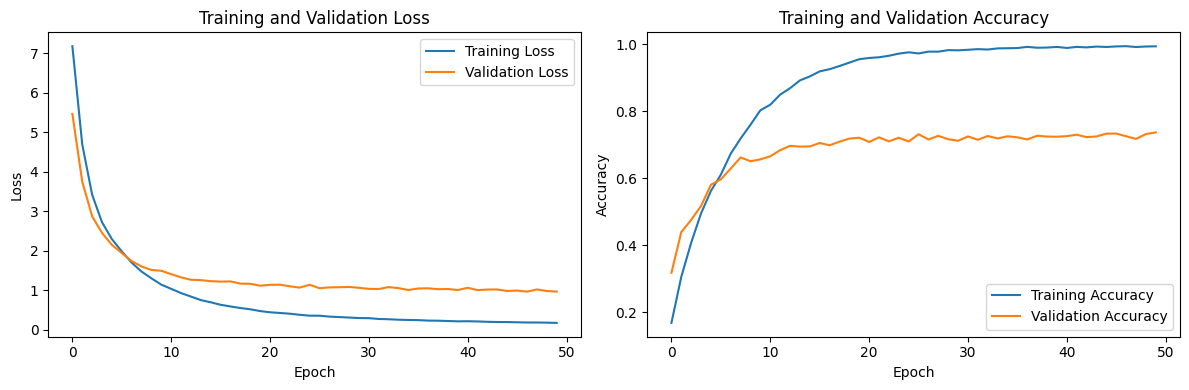

In [ ]:
# Plot training and validation loss and accuracy in subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot accuracy
axes[1].plot(history.history['accuracy'], label='Training Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()


plt.tight_layout()
plt.show()

###**Testing the Model**

In [ ]:
from keras.models import load_model
model = load_model("/content/gdrive/MyDrive/Capstone_Project/trained_model_vgg_with_augm.h5")

In [ ]:
predictions      = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

1/1 [==============================] - 7s 7s/step


In [ ]:
true_labels = test_labels

In [ ]:
# Compute accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy*100:.2f} %')

# Compute precision, recall, and confusion matrix
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
print(f'Weighted Precision: {precision*100:.2f} %')
print(f'Weighted Recall: {recall*100:.2f} %')

Accuracy: 71.18 %
Weighted Precision: 72.11 %
Weighted Recall: 71.18 %


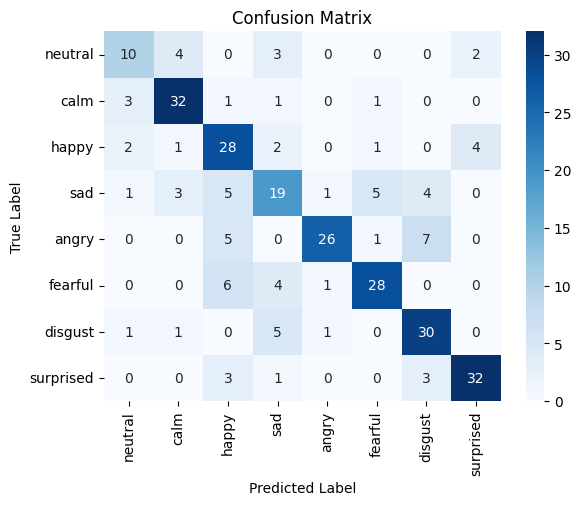

In [ ]:
true_labels = true_labels + 1
predicted_labels = predicted_labels + 1
confusion_mat = confusion_matrix(true_labels, predicted_labels)

class_names = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
# Visualize the confusion matrix as a Seaborn heatmap
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Display the plot
plt.show()